## I. Câu hỏi Machine Learning (Problem Statement)

> **Câu hỏi nghiên cứu:**  
> *Có thể xây dựng mô hình hồi quy (Regression Model) để dự báo nhiệt độ cục bộ (Hyper-local Temperature) tại từng vùng khí hậu đặc thù của TP.HCM trong 24 giờ tới với sai số chấp nhận được (RMSE < 2°C) dựa trên dữ liệu lịch sử 48 giờ trước đó hay không?*

---

### 1. Problem Formulation (Đặt vấn đề)

#### Mục tiêu
- Xây dựng mô hình dự báo chuỗi thời gian (**Time-series Forecasting**) cho biến mục tiêu:
  - `temperature_2m` tại các mốc: t + 1, t + 6, t + 12, t + 24.

#### Phương pháp
- **Multi-zonal Modeling**:
  - Huấn luyện **5 mô hình riêng biệt** cho 5 vùng khí hậu:
    - Center
    - East
    - West
    - South
    - Coastal  
- Mục tiêu là nắm bắt các đặc trưng khí hậu cục bộ của từng vùng.

---

### 2. Feature Engineering (Kỹ thuật đặc trưng)

#### 2.1. Lag Features (Đặc trưng trễ)

Sử dụng **cửa sổ trượt (Sliding Window)** cho các mốc giờ: 1, 3, 6, 12, 24, 36, 48 đối với các biến quan trọng:

- **temperature_2m** – Biến mục tiêu chính  
- **relative_humidity_2m** – Giữ ảnh hưởng độ ẩm tới nhiệt độ  
- **precipitation** – Mưa ảnh hưởng làm giảm nhiệt độ  
- **cloud_cover** – Tỷ lệ mây tổng hợp  
- **wind_speed_10m** – Ảnh hưởng đến cảm nhận nhiệt (chỉ cho HCM_Coastal)

**Lý do:** Thời tiết có tính quán tính (*Inertia*), các giá trị trong quá khứ ảnh hưởng mạnh đến tương lai gần.


#### 2.2. Cyclical Time Features (Đặc trưng thời gian chu kỳ)

Chuyển đổi các biến thời gian thành dạng chu kỳ để giúp mô hình học được tính liên tục:

- **hour_sin, hour_cos** – Biểu diễn giờ trong ngày (0–23)  
- **month_sin, month_cos** – Biểu diễn tháng trong năm (1–12)  
- ** wind_sin, wind_cos** – Biểu diễn hướng gió theo chu kỳ 0–360° (chỉ cho HCM_Coastal)


#### 2.3. Categorical Features (Biến phân loại)

One-hot encoding các biến phân loại quan trọng:

- **season** – Mùa trong năm  
- **day_of_week** – Ngày trong tuần  
- **weather_code** – Loại thời tiết (chỉ giữ các giá trị quan trọng)

#### 2.4. Meta Features

Một số biến được giữ lại để thuận tiện cho gộp dữ liệu và phân vùng:

- **temperature_2m** – Giá trị hiện tại  
- **time** – Thời điểm quan sát  
- **zone** – Vùng khí hậu (Center, East, West, South, Coastal)
---

### 3. Algorithm Selection & Benchmarking (Lựa chọn thuật toán)

Để đánh giá hiệu quả mô hình, nhóm thực hiện **benchmark** giữa 3 thuật toán:


#### 3.1. XGBoost Regressor 
- Thuật toán **Gradient Boosting** tối ưu.
- Kỳ vọng đạt sai số thấp nhất nhờ cơ chế:
  - *Learning from residuals* (học từ sai lầm của các mô hình trước).

### 3.1. Random Forest
**Random Forest** là thuật toán Ensemble Learning dựa trên nhiều cây quyết định:

- **Cơ chế:**
  - **Bagging:** Huấn luyện nhiều cây trên các tập con khác nhau của dữ liệu
  - **Voting:** Kết quả cuối cùng là trung bình của tất cả các cây

- **Ưu điểm:**
  - Giảm overfitting tốt hơn Decision Tree đơn lẻ
  - Robust với outliers và noise
  - Không cần chuẩn hóa dữ liệu
  - Cung cấp **Feature Importance** tự nhiên


#### 3.3 ARIMA
- **Cơ chế:**
  - **AR (AutoRegressive):** Dựa trên giá trị quá khứ
  - **I (Integrated):** Làm chuỗi dừng bằng sai phân
  - **MA (Moving Average):** Dựa trên lỗi dự báo trước đó

- **Ưu điểm:**
  - Dễ triển khai cho từng vùng khí hậu
  - Tốt với dữ liệu lịch sử mượt mà, ít biến động cực đoan

- **Hạn chế:**
  - Không xử lý tốt các biến ngoại sinh (bức xạ mặt trời, áp suất)
  - Cần tối ưu tham số (p,d,q) cho từng vùng để đạt $RMSE < 2°C$


## II. Implement

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.arima.model import ARIMA

from IPython.display import display, HTML

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Đọc dữ liệu
df = pd.read_csv('../data/hcm_weather_processed.csv')
df.shape

(87720, 32)

In [3]:
print(df.keys().tolist())

['time', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'wind_gusts_10m', 'wind_direction_10m', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'shortwave_radiation', 'weather_code', 'vapour_pressure_deficit', 'zone', 'lat', 'lon', 'hour', 'day_of_week', 'month', 'day_of_year', 'year', 'season', 'is_weekend', 'time_of_day', 'is_rainy', 'temp_feel_diff', 'humidity_level', 'wind_level']


In [4]:
# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Cấu hình mốc thời gian 
VAL_CUTOFF = '2025-03-01'   # Từ đây đến Test là Validation 
TEST_CUTOFF = '2025-06-01'  # Từ đây về sau là Test 

ZONES = ['HCM_Center', 'HCM_East', 'HCM_NorthWest', 'HCM_South', 'HCM_Coastal']
HORIZONS = [1, 6, 12, 24]

### 1. XGBoost Regressor

#### a. Hàm Tiền xử lý (Feature Engineering)

In [5]:
def preprocess_features(df_input, zone=None):
    """
    Tiền xử lý dữ liệu cho dự báo nhiệt độ t+24h theo vùng khí hậu.
    
    Args:
        df_input: DataFrame thô, chứa các cột cơ bản như 'time', 'temperature_2m', 'relative_humidity_2m', 'precipitation',
                  'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'hour', 'month', 'season', 'day_of_week', 'weather_code', 'zone'
        zone: str, tên vùng khí hậu ('Coastal', 'Center', 'East', 'West', 'South')
    
    Returns:
        DataFrame gồm các feature đã được tiền xử lý
    """
    data = df_input.copy()
    
    # --- 0. Chuyển đổi time và sắp xếp ---
    data['time'] = pd.to_datetime(data['time'])
    data = data.sort_values('time')
    
    # --- 1. One-Hot Encoding cho categorical ---
    categorical_cols = ['season', 'day_of_week', 'weather_code']
    valid_cats = [c for c in categorical_cols if c in data.columns]
    if 'weather_code' in valid_cats:
        data['weather_code'] = data['weather_code'].astype(str)
    data = pd.get_dummies(data, columns=valid_cats, drop_first=True)
    
    # --- 2. Cyclical Time Features ---
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # --- 3. Wind Direction Features ---
    if 'wind_direction_10m' in data.columns:
        if zone == 'HCM_Coastal':
            data['wind_sin'] = np.sin(2 * np.pi * data['wind_direction_10m'] / 360)
            data['wind_cos'] = np.cos(2 * np.pi * data['wind_direction_10m'] / 360)
        else:
            data['wind_sin'] = 0
            data['wind_cos'] = 0
    
    # --- 4. Lag Features ---
    # Danh sách biến tạo lag
    lag_cols = ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m']
    
    # Mốc lag cho từng biến
    lag_hours = {
        'temperature_2m': [1,3,6,12,24,36,48],
        'relative_humidity_2m': [1,3,6,12,24,36,48],
        'precipitation': [1,3,6,12,24,36,48],
        'cloud_cover': [1,3,6,12],            # Lag dài không cần
        'wind_speed_10m': [1,3,6,12] if zone == 'HCM_Coastal' else []  # Lag ngắn cho Coastal
    }
    
    for col in lag_cols:
        if col in data.columns:
            for i in lag_hours[col]:
                data[f'{col}_lag_{i}'] = data[col].shift(i)
    
    lag_features = [c for c in data.columns if '_lag_' in c]
    
    # --- 5. Gộp cyclical + categorical + meta + lag ---
    cyclical_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'wind_sin', 'wind_cos']
    categorical_features = [c for c in data.columns
                            if c.startswith('season_') or c.startswith('day_of_week_') or c.startswith('weather_code_')]
    
    # Meta features: giữ biến gốc quan trọng + thông tin vùng + thời gian
    meta_features = ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'time', 'zone']
    
    # Các cột cuối cùng để train
    cols_to_keep = lag_features + cyclical_features + categorical_features + meta_features
    
    return data[cols_to_keep]

#### b. Fine-tuning (Tìm tham số tối ưu)
Bước này chạy trước để tìm ra max_depth và learning_rate tốt nhất.

In [6]:
param_grid = [
    {'max_depth': 4, 'learning_rate': 0.05},
    {'max_depth': 6, 'learning_rate': 0.05},
    {'max_depth': 6, 'learning_rate': 0.02},
    {'max_depth': 8, 'learning_rate': 0.02}
]

# Lưu best params theo vùng
best_params_zones = {}

for zone in ZONES:
    print(f"\n>>> BẮT ĐẦU FINE-TUNING vùng {zone}, T+24h ...")
    
    # 1. Lọc vùng & tiền xử lý
    df_zone = df[df['zone'] == zone].copy()
    df_zone = preprocess_features(df_zone, zone=zone)
    
    # 2. Tạo target t+24h
    df_zone['target'] = df_zone['temperature_2m'].shift(-24)
    df_zone = df_zone.dropna()
    
    # 3. Chia Train/Val
    train = df_zone[df_zone['time'] < VAL_CUTOFF]
    val   = df_zone[(df_zone['time'] >= VAL_CUTOFF) & (df_zone['time'] < TEST_CUTOFF)]
    
    # 4. X, y
    cols_to_drop = ['time', 'zone', 'target']  # giữ temperature_2m hiện tại
    X_train = train.drop(columns=cols_to_drop, errors='ignore')
    y_train = train['target']
    X_val = val.drop(columns=cols_to_drop, errors='ignore')
    y_val = val['target']
    
    # In số lượng feature
    print(f"-> Số lượng feature đưa vào model: {X_train.shape[1]}")
    
    # 5. Grid Search
    best_score = float('inf')
    best_params = {}
    
    for params in param_grid:
        
        model = xgb.XGBRegressor(
            n_estimators=1000,
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            early_stopping_rounds=50,  # chỉ dùng khi phiên bản cũ, nếu lỗi thì bỏ vào fit()
            n_jobs=-1,
            random_state=42,
            objective='reg:squarederror',
            eval_metric='rmse'
        )
        
        # Fit model
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        rmse = model.best_score
        print(f"Params: {params} => Val RMSE: {rmse:.4f}")
        
        if rmse < best_score:
            best_score = rmse
            best_params = params
    
    # Lưu best_params cho vùng
    best_params_zones[zone] = best_params
    print(f">>> Vùng {zone} chọn params tối ưu: {best_params}")


>>> BẮT ĐẦU FINE-TUNING vùng HCM_Center, T+24h ...
-> Số lượng feature đưa vào model: 52
Params: {'max_depth': 4, 'learning_rate': 0.05} => Val RMSE: 1.1715
Params: {'max_depth': 6, 'learning_rate': 0.05} => Val RMSE: 1.1688
Params: {'max_depth': 6, 'learning_rate': 0.02} => Val RMSE: 1.1668
Params: {'max_depth': 8, 'learning_rate': 0.02} => Val RMSE: 1.1641
>>> Vùng HCM_Center chọn params tối ưu: {'max_depth': 8, 'learning_rate': 0.02}

>>> BẮT ĐẦU FINE-TUNING vùng HCM_East, T+24h ...
-> Số lượng feature đưa vào model: 52
Params: {'max_depth': 4, 'learning_rate': 0.05} => Val RMSE: 1.1328
Params: {'max_depth': 6, 'learning_rate': 0.05} => Val RMSE: 1.1469
Params: {'max_depth': 6, 'learning_rate': 0.02} => Val RMSE: 1.1474
Params: {'max_depth': 8, 'learning_rate': 0.02} => Val RMSE: 1.1644
>>> Vùng HCM_East chọn params tối ưu: {'max_depth': 4, 'learning_rate': 0.05}

>>> BẮT ĐẦU FINE-TUNING vùng HCM_NorthWest, T+24h ...
-> Số lượng feature đưa vào model: 52
Params: {'max_depth': 4, 'l

#### c. Huấn luyện Chính (Final Training)

In [7]:
final_results_xgb = []
models = {}
test_data = {}

print(f">>> BẮT ĐẦU HUẤN LUYỆN 5 VÙNG x 4 MỐC THỜI GIAN...")

for zone in ZONES:
    print(f"\n--- Xử lý vùng: {zone} ---")
    
    # Lấy tham số tối ưu cho vùng
    zone_params = best_params_zones.get(zone, {'max_depth': 6, 'learning_rate': 0.05})
    print(f"-> Sử dụng params tối ưu: {zone_params}")
    
    # 1. Lọc vùng & Tiền xử lý
    zone_df = df[df['zone'] == zone].copy()
    processed_base = preprocess_features(zone_df,zone=zone)
    
    # Chạy lần lượt các mốc dự báo
    for h in HORIZONS:
        # 2. Tạo Target (Shift ngược h giờ)
        data_h = processed_base.copy()
        data_h['target'] = data_h['temperature_2m'].shift(-h) 
        data_h = data_h.dropna()
        
        # 3. Chia Train/Val/Test (Theo trục thời gian)
        data_train_val = data_h[data_h['time'] < TEST_CUTOFF]
        test = data_h[data_h['time'] >= TEST_CUTOFF]
        
        train = data_train_val[data_train_val['time'] < VAL_CUTOFF]
        val = data_train_val[data_train_val['time'] >= VAL_CUTOFF]
        
        # LỌC DỮ LIỆU ĐẦU VÀO
        cols_to_drop = ['time', 'zone', 'target']
        
        # 4. Tách X, y
        X_train = train.drop(columns=cols_to_drop, errors='ignore')
        y_train = train['target']
        
        X_val = val.drop(columns=cols_to_drop, errors='ignore')
        y_val = val['target']
        
        X_test = test.drop(columns=cols_to_drop, errors='ignore')
        y_test = test['target']
        
        # 5. Huấn luyện Model
        model = xgb.XGBRegressor(
            n_estimators=2000,
            learning_rate=zone_params['learning_rate'],
            max_depth=zone_params['max_depth'],
            early_stopping_rounds=50,
            n_jobs=-1, random_state=42,
            objective='reg:squarederror'
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=False
        )
        
        # 6. Đánh giá
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Lưu kết quả
        final_results_xgb.append({
            'Zone': zone, 
            'Horizon': h, 
            'RMSE': rmse, 
            'MAE': mae, 
            'R2_Score': r2,
            'Best_Iter': model.best_iteration
        })
        
        # Chỉ lưu dữ liệu vẽ biểu đồ cho mốc 24h 
        if h == 24:
            models[zone] = model
            test_data[zone] = {'y_test': y_test, 'preds': preds, 'rmse': rmse}

>>> BẮT ĐẦU HUẤN LUYỆN 5 VÙNG x 4 MỐC THỜI GIAN...

--- Xử lý vùng: HCM_Center ---
-> Sử dụng params tối ưu: {'max_depth': 8, 'learning_rate': 0.02}

--- Xử lý vùng: HCM_East ---
-> Sử dụng params tối ưu: {'max_depth': 4, 'learning_rate': 0.05}

--- Xử lý vùng: HCM_NorthWest ---
-> Sử dụng params tối ưu: {'max_depth': 4, 'learning_rate': 0.05}

--- Xử lý vùng: HCM_South ---
-> Sử dụng params tối ưu: {'max_depth': 4, 'learning_rate': 0.05}

--- Xử lý vùng: HCM_Coastal ---
-> Sử dụng params tối ưu: {'max_depth': 4, 'learning_rate': 0.05}


#### d. Báo cáo Kết quả 

In [8]:
results_df_xgb = pd.DataFrame(final_results_xgb)

def display_large_metric_tables(df):
    metrics = ['RMSE', 'MAE', 'R2_Score']
    cmaps = {'RMSE': 'Reds', 'MAE': 'Blues', 'R2_Score': 'Greens'}
    
    # CSS để ép bảng to ra và chữ dễ đọc hơn
    large_table_css = [
        {'selector': '', 'props': [('width', '100%'), ('margin-bottom', '40px')]},
        {'selector': 'th', 'props': [('font-size', '15px'), ('text-align', 'center'), ('padding', '15px'), ('background-color', '#f4f4f4')]},
        {'selector': 'td', 'props': [('font-size', '14px'), ('padding', '15px'), ('text-align', 'center')]},
        {'selector': 'caption', 'props': [('font-size', '18px'), ('font-weight', 'bold'), ('margin-bottom', '10px'), ('color', '#333')]}
    ]

    for m in metrics:
        # 1. Tạo Pivot
        metric_df = df.pivot_table(index='Zone', columns='Horizon', values=m)
        metric_df.columns = [f"Horizon {col}h" for col in metric_df.columns]
        
        # 2. Áp dụng Style
        styled_table = metric_df.style \
            .background_gradient(cmap=cmaps[m], axis=None) \
            .format("{:.3f}") \
            .set_caption(f">>> Bảng thống kê {m} ") \
            .set_table_styles(large_table_css)
        
        # 3. Hiển thị
        display(styled_table)
        print("-" * 100) # Đường kẻ phân cách giữa các bảng

# Chạy hàm với results_df của bạn
display_large_metric_tables(results_df_xgb)

,Horizon 1h,Horizon 6h,Horizon 12h,Horizon 24h
Zone,,,,
HCM_Center,0.664,1.105,1.134,1.156
HCM_Coastal,0.733,1.112,1.155,1.177
HCM_East,0.636,1.094,1.097,1.124
HCM_NorthWest,0.679,1.080,1.095,1.137
HCM_South,0.691,1.124,1.098,1.135


----------------------------------------------------------------------------------------------------


,Horizon 1h,Horizon 6h,Horizon 12h,Horizon 24h
Zone,,,,
HCM_Center,0.386,0.813,0.821,0.842
HCM_Coastal,0.447,0.812,0.850,0.869
HCM_East,0.384,0.808,0.795,0.825
HCM_NorthWest,0.402,0.802,0.787,0.823
HCM_South,0.403,0.826,0.791,0.823


----------------------------------------------------------------------------------------------------


,Horizon 1h,Horizon 6h,Horizon 12h,Horizon 24h
Zone,,,,
HCM_Center,0.919,0.776,0.764,0.754
HCM_Coastal,0.882,0.729,0.708,0.695
HCM_East,0.922,0.768,0.767,0.755
HCM_NorthWest,0.927,0.816,0.811,0.795
HCM_South,0.910,0.763,0.774,0.757


----------------------------------------------------------------------------------------------------


#### e - Feature Importance  

<Figure size 1000x600 with 0 Axes>

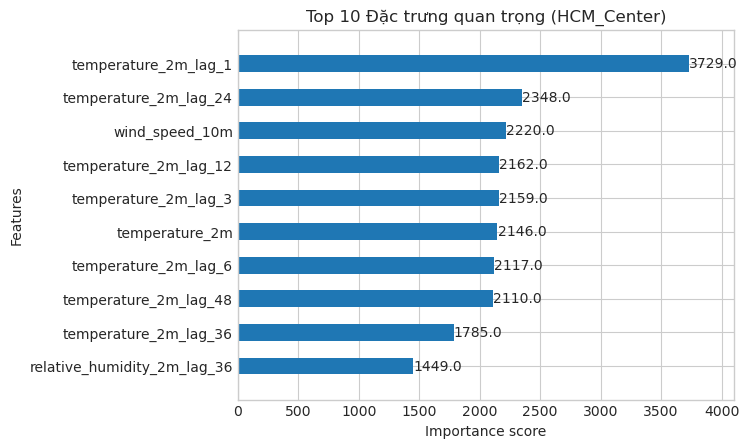

In [9]:
# Feature Importance
model_center = models['HCM_Center']
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_center, max_num_features=10, height=0.5, importance_type='weight', title='Top 10 Đặc trưng quan trọng (HCM_Center)')
plt.show()

#### f. Residual Analysis

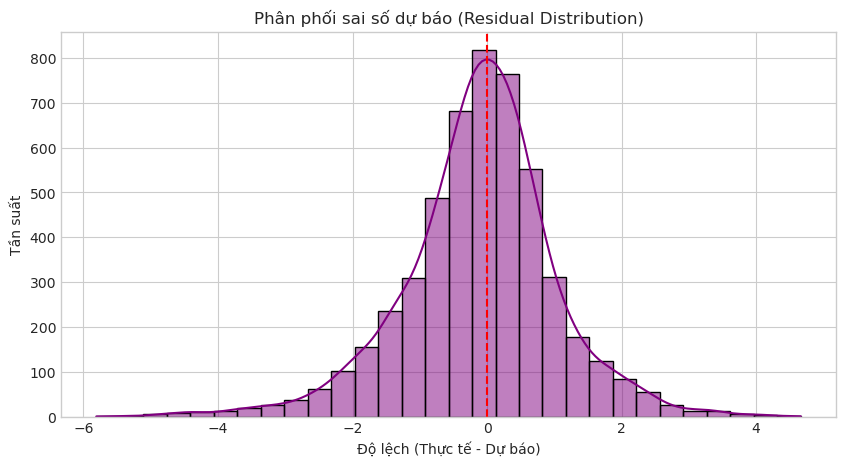


=== THỐNG KÊ SAI SỐ (HCM_East) ===
Trung bình: -0.1151°C (Gần 0 là tốt)
Độ lệch chuẩn: 1.1500°C
Min: -5.8090°C
Max: 4.6627°C


In [10]:
# Residual Analysis (Phân tích phân phối lỗi)
# Lỗi = Thực tế - Dự báo
residuals = test_data['HCM_Center']['y_test'] - test_data['HCM_Center']['preds']

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title('Phân phối sai số dự báo (Residual Distribution)')
plt.xlabel('Độ lệch (Thực tế - Dự báo)')
plt.ylabel('Tần suất')
plt.show()

# Thống kê residuals
print("\n" + "="*80)
print("=== THỐNG KÊ SAI SỐ (HCM_East) ===")
print("="*80)
print(f"Trung bình: {residuals.mean():.4f}°C (Gần 0 là tốt)")
print(f"Độ lệch chuẩn: {residuals.std():.4f}°C")
print(f"Min: {residuals.min():.4f}°C")
print(f"Max: {residuals.max():.4f}°C")

### 2. Random Forest Regressor
#### a. Hàm tiền xử lý (Tương tự XGBoost)
#### b. FINE-TUNING (TÌM THAM SỐ TỐI ƯU)

In [11]:
best_params_zones_rf = {}  # Lưu best params cho từng vùng

print(">>> BẮT ĐẦU FINE-TUNING Random Forest cho tất cả vùng, T+24h...")

# Lưới tham số RF
param_grid = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5},
    {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5},
    {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}
]

for zone in ZONES:
    print(f"\n--- Fine-tuning vùng: {zone} ---")
    
    # 1. Lọc vùng & tiền xử lý
    df_zone = df[df['zone'] == zone].copy()
    df_zone = preprocess_features(df_zone, zone=zone)
    
    # 2. Tạo target t+24h
    df_zone['target'] = df_zone['temperature_2m'].shift(-24)
    df_zone = df_zone.dropna()
    
    # 3. Chia Train/Val
    train = df_zone[df_zone['time'] < VAL_CUTOFF]
    val   = df_zone[(df_zone['time'] >= VAL_CUTOFF) & (df_zone['time'] < TEST_CUTOFF)]
    
    # 4. Lọc dữ liệu đầu vào
    cols_to_drop = ['time', 'zone', 'target']
    X_train = train.drop(columns=cols_to_drop, errors='ignore')
    y_train = train['target']
    X_val   = val.drop(columns=cols_to_drop, errors='ignore')
    y_val   = val['target']
    
    print(f"-> Vùng {zone}: số lượng Features: {X_train.shape[1]}")
    
    # 5. Grid Search
    best_score = float('inf')
    best_params = {}
    
    for params in param_grid:
        model = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        preds_val = model.predict(X_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, preds_val))
        
        print(f"Params: {params} => Val RMSE: {rmse_val:.4f}")
        
        if rmse_val < best_score:
            best_score = rmse_val
            best_params = params
    
    best_params_zones_rf[zone] = best_params
    print(f">>> Vùng {zone} chọn params tối ưu: {best_params}")

>>> BẮT ĐẦU FINE-TUNING Random Forest cho tất cả vùng, T+24h...

--- Fine-tuning vùng: HCM_Center ---
-> Vùng HCM_Center: số lượng Features: 52
Params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5} => Val RMSE: 1.1829
Params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5} => Val RMSE: 1.1844
Params: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10} => Val RMSE: 1.1849
Params: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10} => Val RMSE: 1.1836
>>> Vùng HCM_Center chọn params tối ưu: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}

--- Fine-tuning vùng: HCM_East ---
-> Vùng HCM_East: số lượng Features: 52
Params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5} => Val RMSE: 1.1651
Params: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5} => Val RMSE: 1.1664
Params: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10} => Val RMSE: 1.1667
Params: {'n_estimators': 200, 'max_de

#### c.HUẤN LUYỆN CHÍNH (FINAL TRAINING)

In [12]:
final_results_rf = []
models = {}
test_data = {}


print(f"\n>>> BẮT ĐẦU HUẤN LUYỆN 5 VÙNG x 4 MỐC THỜI GIAN...")

for zone in ZONES:
    print(f"\n--- Xử lý vùng: {zone} ---")
    
    # Lấy tham số tối ưu cho vùng
    zone_params = best_params_zones_rf.get(zone, {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10})
    print(f"-> Tham số tối ưu vùng {zone}: {zone_params}")
    
    # 1. Lọc vùng & Tiền xử lý
    zone_df = df[df['zone'] == zone].copy()
    processed_base = preprocess_features(zone_df,zone)
    
    # Chạy lần lượt các mốc dự báo
    for h in HORIZONS:
        # 2. Tạo Target (Shift ngược h giờ)
        data_h = processed_base.copy()
        data_h['target'] = data_h['temperature_2m'].shift(-h)
        data_h = data_h.dropna()
        
        # 3. Chia Train/Val/Test (Theo trục thời gian)
        data_train_val = data_h[data_h['time'] < TEST_CUTOFF]
        test = data_h[data_h['time'] >= TEST_CUTOFF]
        train = data_train_val[data_train_val['time'] < VAL_CUTOFF]
        val = data_train_val[data_train_val['time'] >= VAL_CUTOFF]
        
        # Lọc dữ liệu đầu vào
        cols_to_drop = ['time', 'zone', 'target']
        
        # 4. Tách X, y
        X_train = train.drop(columns=cols_to_drop, errors='ignore')
        y_train = train['target']
        
        X_val = val.drop(columns=cols_to_drop, errors='ignore')
        y_val = val['target']
        
        X_test = test.drop(columns=cols_to_drop, errors='ignore')
        y_test = test['target']
        
        # 5. Huấn luyện Model
        model = RandomForestRegressor(
            n_estimators=zone_params['n_estimators'],
            max_depth=zone_params['max_depth'],
            min_samples_split=zone_params['min_samples_split'],
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        
        # 6. Đánh giá
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Lưu kết quả
        final_results_rf.append({
            'Zone': zone,
            'Horizon': h,
            'Model': 'Random Forest',
            'RMSE': rmse,
            'MAE': mae,
            'R2_Score': r2
        })
        
        # Chỉ lưu dữ liệu vẽ biểu đồ cho mốc 24h
        if h == 24:
            models[zone] = model
            test_data[zone] = {'y_test': y_test, 'preds': preds, 'rmse': rmse}



>>> BẮT ĐẦU HUẤN LUYỆN 5 VÙNG x 4 MỐC THỜI GIAN...

--- Xử lý vùng: HCM_Center ---
-> Tham số tối ưu vùng HCM_Center: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}

--- Xử lý vùng: HCM_East ---
-> Tham số tối ưu vùng HCM_East: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}

--- Xử lý vùng: HCM_NorthWest ---
-> Tham số tối ưu vùng HCM_NorthWest: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}

--- Xử lý vùng: HCM_South ---
-> Tham số tối ưu vùng HCM_South: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 10}

--- Xử lý vùng: HCM_Coastal ---
-> Tham số tối ưu vùng HCM_Coastal: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}


#### d. Báo cáo kết quả

In [13]:
results_df_rf = pd.DataFrame(final_results_rf)

def display_large_metric_tables(df):
    metrics = ['RMSE', 'MAE', 'R2_Score']
    cmaps = {'RMSE': 'Reds', 'MAE': 'Blues', 'R2_Score': 'Greens'}
    
    # CSS để ép bảng to ra và chữ dễ đọc hơn
    large_table_css = [
        {'selector': '', 'props': [('width', '100%'), ('margin-bottom', '40px')]},
        {'selector': 'th', 'props': [('font-size', '15px'), ('text-align', 'center'), ('padding', '15px'), ('background-color', '#f4f4f4')]},
        {'selector': 'td', 'props': [('font-size', '14px'), ('padding', '15px'), ('text-align', 'center')]},
        {'selector': 'caption', 'props': [('font-size', '18px'), ('font-weight', 'bold'), ('margin-bottom', '10px'), ('color', '#333')]}
    ]

    for m in metrics:
        # 1. Tạo Pivot
        metric_df = df.pivot_table(index='Zone', columns='Horizon', values=m)
        metric_df.columns = [f"Horizon {col}h" for col in metric_df.columns]
        
        # 2. Áp dụng Style
        styled_table = metric_df.style \
            .background_gradient(cmap=cmaps[m], axis=None) \
            .format("{:.3f}") \
            .set_caption(f">>> Bảng thống kê {m} ") \
            .set_table_styles(large_table_css)
        
        # 3. Hiển thị
        display(styled_table)
        print("-" * 100) # Đường kẻ phân cách giữa các bảng

# Chạy hàm với results_df của bạn
display_large_metric_tables(results_df_rf)

,Horizon 1h,Horizon 6h,Horizon 12h,Horizon 24h
Zone,,,,
HCM_Center,0.677,1.114,1.146,1.163
HCM_Coastal,0.746,1.128,1.170,1.186
HCM_East,0.641,1.066,1.118,1.134
HCM_NorthWest,0.691,1.078,1.129,1.141
HCM_South,0.680,1.092,1.131,1.149


----------------------------------------------------------------------------------------------------


,Horizon 1h,Horizon 6h,Horizon 12h,Horizon 24h
Zone,,,,
HCM_Center,0.392,0.804,0.831,0.845
HCM_Coastal,0.453,0.825,0.866,0.875
HCM_East,0.381,0.761,0.812,0.830
HCM_NorthWest,0.401,0.776,0.820,0.826
HCM_South,0.395,0.795,0.817,0.834


----------------------------------------------------------------------------------------------------


,Horizon 1h,Horizon 6h,Horizon 12h,Horizon 24h
Zone,,,,
HCM_Center,0.916,0.773,0.759,0.751
HCM_Coastal,0.878,0.722,0.700,0.689
HCM_East,0.921,0.780,0.758,0.750
HCM_NorthWest,0.925,0.817,0.799,0.794
HCM_South,0.913,0.777,0.760,0.751


----------------------------------------------------------------------------------------------------


#### e. FEATURE IMPORTANCE

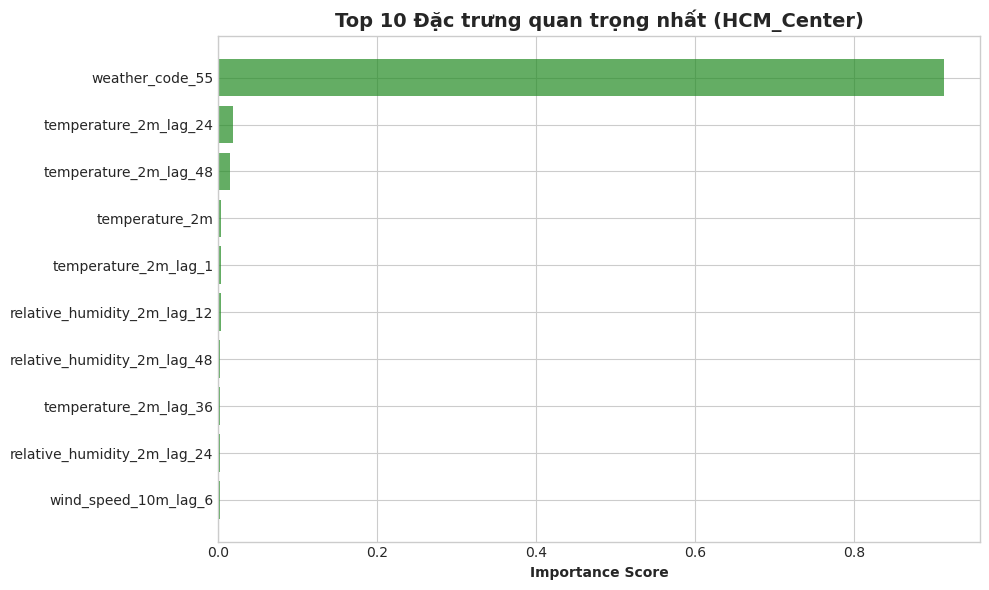

In [14]:
# Feature Importance 
model_center = models['HCM_Center']

# Lấy importance
importances = model_center.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1][:10]  # Top 10

plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[indices], color='forestgreen', alpha=0.7)
plt.yticks(range(10), [feature_names[i] for i in indices])
plt.xlabel('Importance Score', fontweight='bold')
plt.title('Top 10 Đặc trưng quan trọng nhất (HCM_Center)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### f. RESIDUAL ANALYSIS

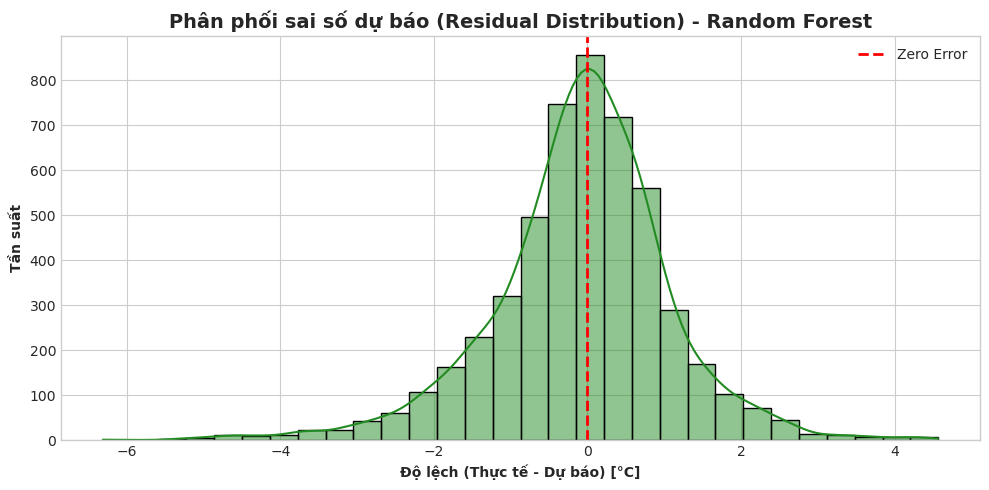


=== THỐNG KÊ SAI SỐ (HCM_Center) ===
Trung bình: -0.0846°C (Gần 0 là tốt)
Độ lệch chuẩn: 1.1600°C
Min: -6.3108°C
Max: 4.5690°C


In [15]:
# Phân tích phân phối lỗi (Residuals)
residuals = test_data['HCM_Center']['y_test'] - test_data['HCM_Center']['preds']

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='forestgreen', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Phân phối sai số dự báo (Residual Distribution) - Random Forest', 
          fontsize=14, fontweight='bold')
plt.xlabel('Độ lệch (Thực tế - Dự báo) [°C]', fontweight='bold')
plt.ylabel('Tần suất', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# Thống kê residuals
print("\n" + "="*80)
print("=== THỐNG KÊ SAI SỐ (HCM_Center) ===")
print("="*80)
print(f"Trung bình: {residuals.mean():.4f}°C (Gần 0 là tốt)")
print(f"Độ lệch chuẩn: {residuals.std():.4f}°C")
print(f"Min: {residuals.min():.4f}°C")
print(f"Max: {residuals.max():.4f}°C")

### 3. ARIMA

In [16]:
# Candidate ARIMA orders (small grid)
p_values = [0,1,2]
d_values = [0,1]
q_values = [0,1,2]

# Lưu kết quả
results_arima = []

# Chạy ARIMA cho từng zone
for zone in ZONES:
    print(f"\n=== Zone: {zone} ===")
    
    # 1 Chuỗi thời gian
    zone_df = df[df['zone']==zone].copy()
    zone_df['time'] = pd.to_datetime(zone_df['time'])
    zone_df = zone_df.sort_values('time').set_index('time')
    series = zone_df['temperature_2m'].asfreq('H').ffill()
    
    # 2 Chia train / val / test
    train_series = series[series.index < VAL_CUTOFF]
    val_series   = series[(series.index >= VAL_CUTOFF) & (series.index < TEST_CUTOFF)]
    test_series  = series[series.index >= TEST_CUTOFF]
    
    # 3 Tune (train → val RMSE)
    best_rmse = np.inf
    best_order = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train_series, order=(p,d,q))
                    fitted = model.fit()
                    
                    # Forecast trên validation
                    val_forecast = fitted.forecast(steps=len(val_series))
                    
                    # Tính RMSE
                    rmse_val = np.sqrt(mean_squared_error(val_series, val_forecast))
                    
                    if rmse_val < best_rmse:
                        best_rmse = rmse_val
                        best_order = (p,d,q)
                except:
                    continue
    
    if best_order is None:
        print("Không tìm được order phù hợp, bỏ qua zone")
        continue
    
    print(f"→ Best ARIMA order (val RMSE): {best_order} | RMSE={best_rmse:.3f}")
    
   
    # 4 Fit final trên train+val
    train_val_series = pd.concat([train_series, val_series])
    final_model = ARIMA(train_val_series, order=best_order).fit()
    
    for h in HORIZONS:
        if len(test_series) < h:
            continue
        forecast = final_model.forecast(steps=h)
        y_true = test_series.iloc[:h]
        
        rmse = np.sqrt(mean_squared_error(y_true, forecast))
        mae  = mean_absolute_error(y_true, forecast)
        
        results_arima.append({
            'Zone': zone,
            'Horizon': h,
            'Model': f'ARIMA{best_order}',
            'RMSE': rmse,
            'MAE': mae
        })
        
        print(f"Horizon {h}h | RMSE={rmse:.3f} | MAE={mae:.3f}")

# Tổng hợp kết quả
results_df_arima = pd.DataFrame(results_arima)
display(results_df_arima)


=== Zone: HCM_Center ===
→ Best ARIMA order (val RMSE): (2, 1, 2) | RMSE=3.063
Horizon 1h | RMSE=0.438 | MAE=0.438
Horizon 6h | RMSE=0.709 | MAE=0.572
Horizon 12h | RMSE=1.227 | MAE=0.939
Horizon 24h | RMSE=1.947 | MAE=1.477

=== Zone: HCM_East ===
→ Best ARIMA order (val RMSE): (2, 1, 2) | RMSE=3.056
Horizon 1h | RMSE=0.081 | MAE=0.081
Horizon 6h | RMSE=0.738 | MAE=0.547
Horizon 12h | RMSE=1.127 | MAE=0.882
Horizon 24h | RMSE=1.904 | MAE=1.386

=== Zone: HCM_NorthWest ===
→ Best ARIMA order (val RMSE): (2, 1, 2) | RMSE=3.300
Horizon 1h | RMSE=0.378 | MAE=0.378
Horizon 6h | RMSE=1.018 | MAE=0.808
Horizon 12h | RMSE=1.454 | MAE=1.200
Horizon 24h | RMSE=2.078 | MAE=1.565

=== Zone: HCM_South ===
→ Best ARIMA order (val RMSE): (2, 1, 2) | RMSE=3.048
Horizon 1h | RMSE=0.228 | MAE=0.228
Horizon 6h | RMSE=0.608 | MAE=0.486
Horizon 12h | RMSE=1.346 | MAE=0.981
Horizon 24h | RMSE=2.006 | MAE=1.490

=== Zone: HCM_Coastal ===
→ Best ARIMA order (val RMSE): (1, 0, 0) | RMSE=2.182
Horizon 1h | RM

,Zone,Horizon,Model,RMSE,MAE
0,HCM_Center,1,"ARIMA(2, 1, 2)",0.438355,0.438355
1,HCM_Center,6,"ARIMA(2, 1, 2)",0.709485,0.572349
2,HCM_Center,12,"ARIMA(2, 1, 2)",1.227479,0.938960
3,HCM_Center,24,"ARIMA(2, 1, 2)",1.947478,1.477259
4,HCM_East,1,"ARIMA(2, 1, 2)",0.080943,0.080943
5,HCM_East,6,"ARIMA(2, 1, 2)",0.737960,0.546590
6,HCM_East,12,"ARIMA(2, 1, 2)",1.127417,0.881791
7,HCM_East,24,"ARIMA(2, 1, 2)",1.904301,1.386387
8,HCM_NorthWest,1,"ARIMA(2, 1, 2)",0.377893,0.377893
9,HCM_NorthWest,6,"ARIMA(2, 1, 2)",1.017736,0.808254


## III. So sánh các mô hình

In [17]:
# 1. Thêm tên Model cho XGBoost (trong hình chưa có cột này)
results_df_xgb['Model'] = 'XGBoost'

# 2. Xử lý tên Model cho ARIMA (để gom nhóm cho gọn)
# Nếu bạn muốn giữ nguyên tham số (2,1,2) thì bỏ qua dòng này
results_df_arima['Model'] = 'ARIMA' 

# 3. Chọn các cột chung để so sánh (RMSE và MAE là quan trọng nhất)
common_cols = ['Zone', 'Horizon', 'Model', 'RMSE', 'MAE']

# 4. Gộp tất cả lại thành 1 DataFrame lớn
df_all = pd.concat([
    results_df_xgb[common_cols],
    results_df_rf[common_cols],
    results_df_arima[common_cols]
], ignore_index=True)

# Hiển thị mẫu dữ liệu sau khi gộp
display(df_all)

,Zone,Horizon,Model,RMSE,MAE
0,HCM_Center,1,XGBoost,0.663909,0.386465
1,HCM_Center,6,XGBoost,1.105001,0.813244
2,HCM_Center,12,XGBoost,1.134354,0.820897
3,HCM_Center,24,XGBoost,1.155663,0.841640
4,HCM_East,1,XGBoost,0.635892,0.383653
5,HCM_East,6,XGBoost,1.094444,0.808444
6,HCM_East,12,XGBoost,1.096597,0.794654
7,HCM_East,24,XGBoost,1.123501,0.825085
8,HCM_NorthWest,1,XGBoost,0.678840,0.401979
9,HCM_NorthWest,6,XGBoost,1.080386,0.801520


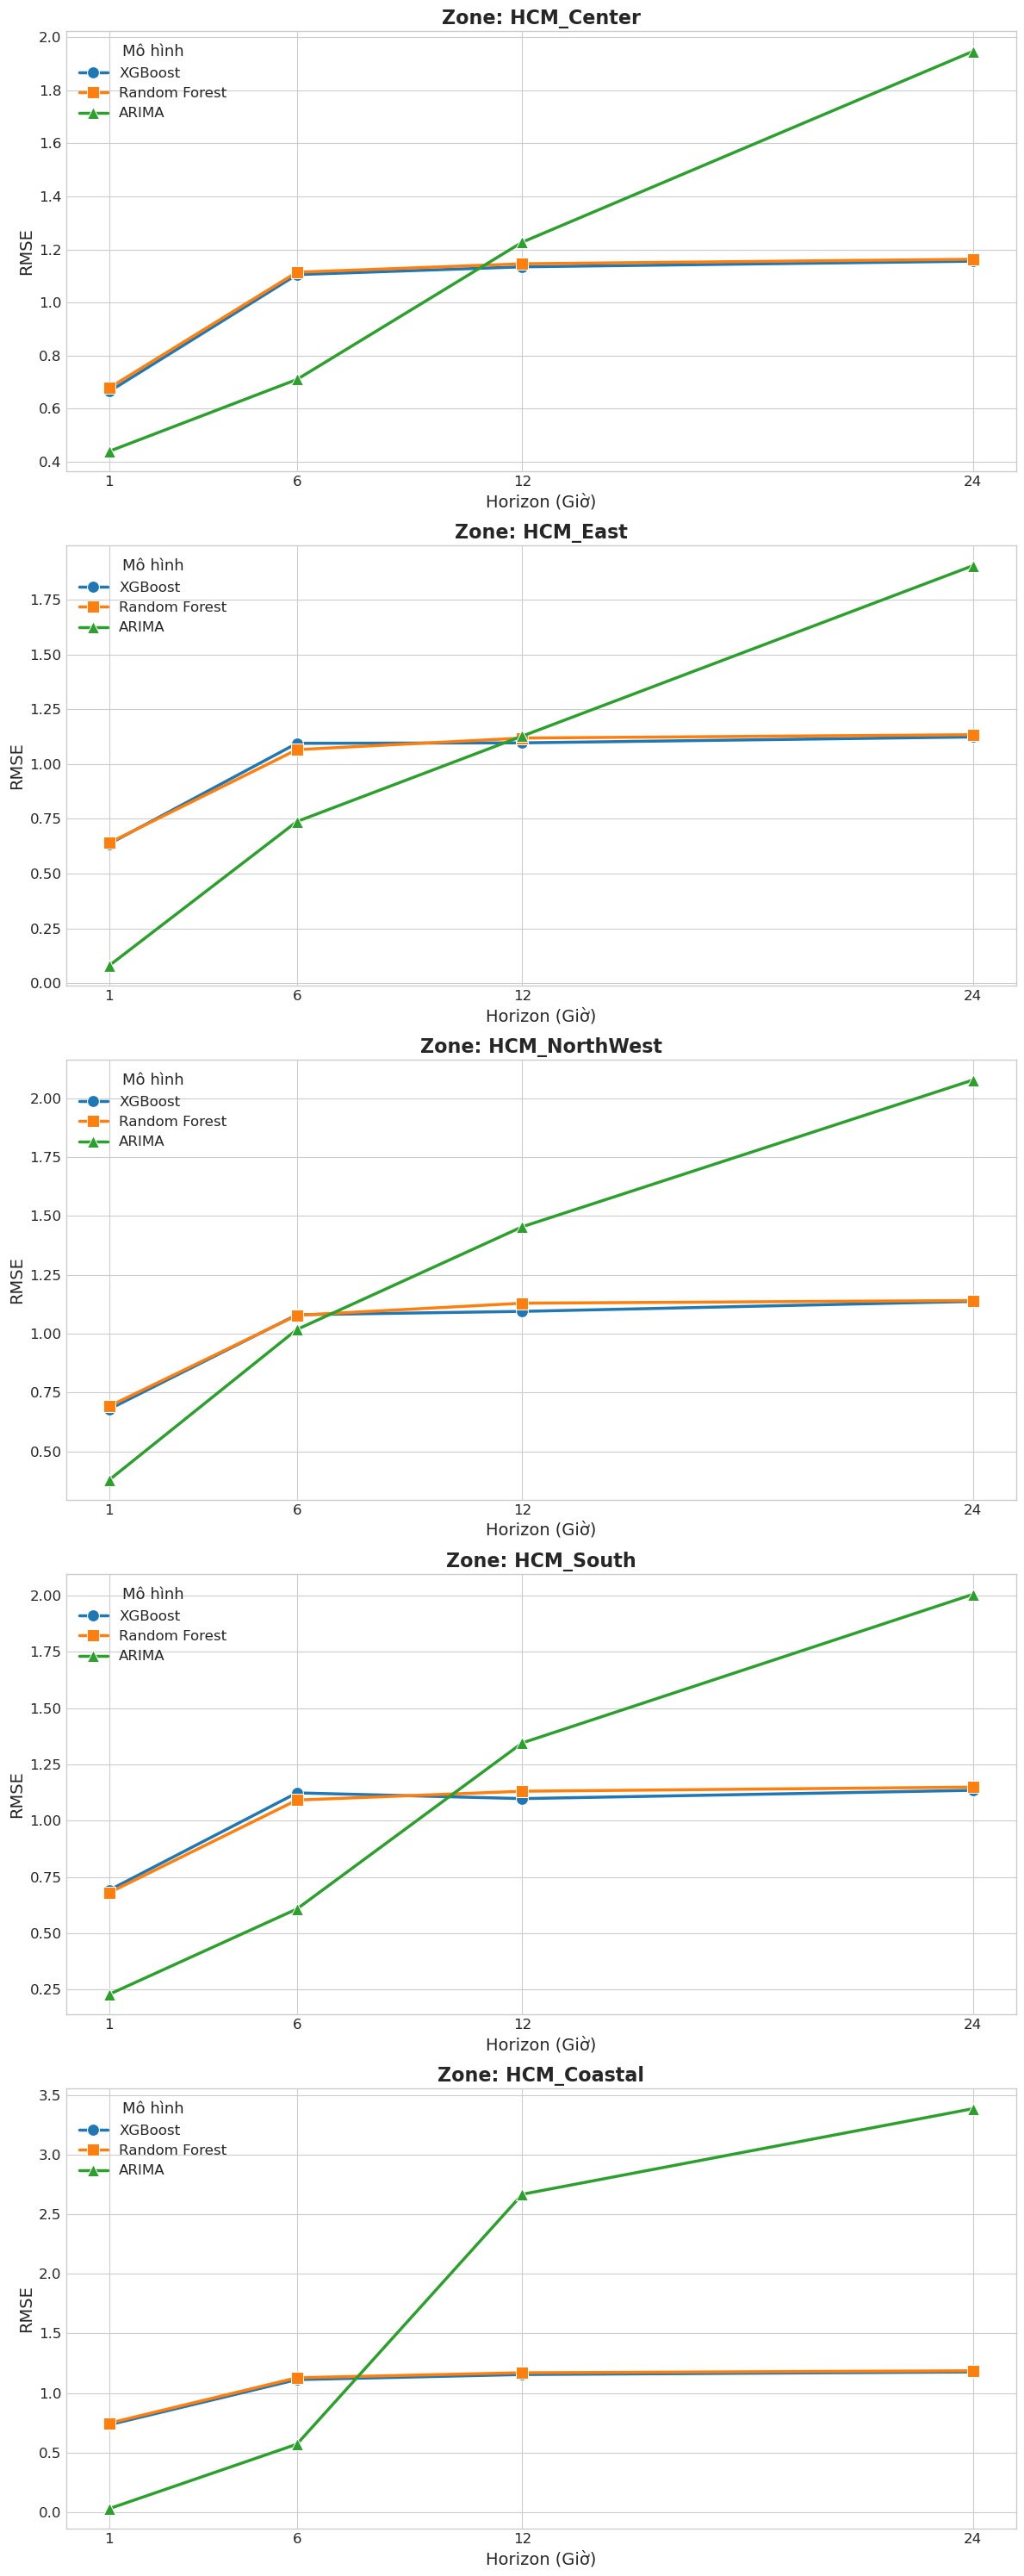

In [18]:
zones = df_all['Zone'].unique()
num_zones = len(zones) # Đếm số lượng Zone để chia dòng tự động

# Cấu hình kích thước: 
# Chiều rộng 12, Chiều cao = 6 * số lượng zone (để đảm bảo mỗi hình đủ to)
plt.figure(figsize=(12, 6 * num_zones)) 
sns.set_style("whitegrid")

# Định nghĩa marker
custom_markers = {"XGBoost": "o", "Random Forest": "s", "ARIMA": "^"}

for i, zone in enumerate(zones):
    # Thay đổi quan trọng ở đây: (num_zones, 1, i+1) -> Nghĩa là N dòng, 1 cột
    plt.subplot(num_zones, 1, i+1)
    
    data_zone = df_all[df_all['Zone'] == zone]
    
    sns.lineplot(
        data=data_zone, 
        x='Horizon', 
        y='RMSE', 
        hue='Model', 
        style='Model', 
        markers=custom_markers, 
        dashes=False, 
        markersize=10, 
        linewidth=2.5
    )
    
    plt.title(f'Zone: {zone}', fontsize=16, fontweight='bold')
    plt.ylabel('RMSE', fontsize=14)
    plt.xlabel('Horizon (Giờ)', fontsize=14)
    plt.xticks([1, 6, 12, 24], fontsize=12) # Chỉnh cỡ chữ trục X
    plt.yticks(fontsize=12)                 # Chỉnh cỡ chữ trục Y
    
    # Thêm legend (chú thích) rõ ràng cho từng hình (hoặc có thể chỉ để ở hình đầu tiên)
    plt.legend(title='Mô hình', title_fontsize='13', fontsize='12', loc='upper left')

plt.tight_layout()
plt.show()

#### 1. Đánh giá Tổng quan

Dựa trên chỉ số đánh giá $RMSE$ và $MAE$ trên toàn bộ các khu vực (Zone) và các khoảng dự báo (Horizon: 1h, 6h, 12h, 24h), kết quả thực nghiệm cho thấy:

- **XGBoost** là mô hình có độ ổn định cao nhất và hiệu năng tổng thể vượt trội, đặc biệt chứng minh được ưu thế trong dự báo trung và dài hạn (6–24h).  
- **Random Forest** có xu hướng bám sát hiệu năng của XGBoost nhưng chỉ số sai số thường cao hơn một chút, cho thấy khả năng tổng quát hóa kém hơn so với kỹ thuật Boosting.  
- **ARIMA** thể hiện sự phân cực rõ rệt: cực kỳ chính xác trong ngắn hạn (1h) nhưng suy giảm hiệu năng nghiêm trọng khi mở rộng khung thời gian dự báo.


#### 2. Phân tích chi tiết theo Horizon (Khoảng dự báo)

##### a. Ngắn hạn (Horizon = 1 giờ)

- **ARIMA** đạt độ chính xác cao nhất với $RMSE < 0.5$ (thậm chí $< 0.1$ tại một số Zone).  
  Điều này khẳng định ARIMA tận dụng rất tốt tính tự hồi quy (*Autoregressive*) và sự phụ thuộc ngắn hạn của chuỗi dữ liệu.
- Các mô hình **Machine Learning** (XGBoost, Random Forest) có sai số cao hơn  
  ($RMSE \approx 0.63 - 0.75$), do các mô hình này cần nhiều dữ liệu và đặc trưng phức tạp hơn để tối ưu hóa cho bước nhảy đơn lẻ.

##### b. Trung và dài hạn (Horizon = 6, 12, 24 giờ)

- Tại **Horizon 6h**, khoảng cách hiệu năng giữa ARIMA và ML bắt đầu thu hẹp. XGBoost bắt đầu bắt kịp và vượt qua ARIMA ở nhiều khu vực.
- Tại **Horizon 12h và 24h**, mô hình ARIMA bộc lộ hạn chế của các phương pháp tuyến tính khi sai số tích lũy tăng vọt  
  ($RMSE > 1.5$, cá biệt > 3.0).
- Ngược lại, **XGBoost** và **Random Forest** duy trì mức sai số ổn định  
  ($RMSE \approx 1.1 - 1.2$).  
  Điều này chứng minh khả năng của các mô hình phi tuyến trong việc nắm bắt các mẫu dài hạn mà không bị ảnh hưởng bởi sai số tích lũy như mô hình chuỗi thời gian truyền thống.


#### 3. So sánh các mô hình Machine Learning: XGBoost vs. Random Forest

- Trên hầu hết các tập dữ liệu kiểm thử, **XGBoost** luôn đạt $RMSE$ và $MAE$ thấp hơn so với **Random Forest**.
- Kết quả này phản ánh ưu thế của kỹ thuật **Gradient Boosting** (tối ưu hóa sai số của các cây trước đó) so với kỹ thuật **Bagging** của Random Forest (trung bình các cây độc lập).  
- **XGBoost** xử lý tốt hơn các mối quan hệ phi tuyến phức tạp và giảm thiểu *Bias* hiệu quả hơn.


#### 4. Nhận xét theo Khu vực (Zone)

- Các khu vực đô thị hoặc ổn định như **HCM_Center**, **HCM_East**, **HCM_South** cho kết quả dự báo tốt với sai số thấp.
- **HCM_Coastal** được ghi nhận là khu vực khó dự báo nhất, đặc biệt với ARIMA.  
  Nguyên nhân có thể xuất phát từ tính chất khí hậu vùng ven biển có độ biến động (*variance*) cao và chịu ảnh hưởng bởi nhiều yếu tố nhiễu ngoại lai, làm giảm khả năng dự báo của các mô hình thống kê.


## 5. Kết luận

- **ARIMA** chỉ nên được sử dụng cho bài toán dự báo tức thời (*One-step ahead*, t+1h).
- **XGBoost** là lựa chọn tối ưu nhất cho hệ thống dự báo thực tế nhờ sự cân bằng giữa độ chính xác và tính ổn định qua các mốc thời gian.
- **Đề xuất chiến lược vận hành:**
  - **Dự báo 1 giờ tới:** sử dụng ARIMA để tận dụng tính tự hồi quy ngắn hạn.
  - **Dự báo từ 6 giờ trở đi:** chuyển sang XGBoost để tối ưu hiệu năng và duy trì $RMSE < 2°C$.
